In [1]:
import geopandas
import matplotlib.pyplot as plt
import math
import pandas
import shapely
import numpy
import datetime

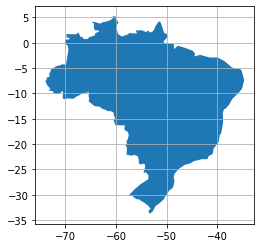

In [2]:
# Loading the geometries
fig, ax = plt.subplots()
ax.grid(True)

polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
polygons = polygons[polygons.name =='Brazil']

polygons.plot(ax=ax)

geom_type = polygons.iloc[0].geometry.type
if  geom_type == 'Polygon':
    lon, lat = polygons.iloc[0].geometry.exterior.xy
elif geom_type == 'MultiPolygon':
    lon = []
    lat = []
    for p in list(polygons.iloc[0].geometry):
        lon += p.exterior.xy[0]
        lat += p.exterior.xy[1]

In [3]:
# We drop the last point because it is a repetition of the first point
lon = numpy.array(lon)[0:-1]
lat = numpy.array(lat)[0:-1]

# We convert to ECEF vectors
x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

# We create a nx3 matrix of the points 
nodes = numpy.array([x, y, z]).transpose()

n = len(x)
n

202

In [4]:
# We create an nxn matrix of the cross products. 
# We apply some broadcasting magic https://stackoverflow.com/questions/49931993/element-wise-cross-product-of-vectors-contained-in-2-arrays-with-python

great_circles = numpy.cross(nodes[:,None,:], nodes) 

In [5]:
# We calculate the dot prodcuts of every great circle with every node. 
# If the dot product is positive, the node is in the hemisphere defined 
# by the great circle
# i is the dimension of the ecef vector
# j is the dimension of the nodes 
# k,m are the dimensions of the nodes the great circle is passing through
dots = numpy.einsum('ji,kmi->jkm', nodes, great_circles)
dots.shape

(202, 202, 202)

In [6]:
# Due to floating point precission, it can happen that a node appears to be on the wrong side of the great circle
# that passes through it.
# To avoid this, we manually set the dot product of nodes to 1 for the great circles that pass through them

for i in range(n):
    dots[i,:,i] = 1
    dots[i,i,:] = 1

In [7]:
# We pull out the great circles that have all nodes on their side.

convex_hull_gc = great_circles[numpy.sum(dots>0, axis=0)==n]

# Below here is just visualization

In [8]:
# We get the (node) indices k,m of the constraints, lookup the nodes and create line segments

k,m = numpy.where(numpy.sum(dots>0, axis=0)==n)

lines = []
for i in range(len(k)):
    lines.append(shapely.geometry.LineString([(lon[k][i], lat[k][i]), (lon[m][i], lat[m][i])]))

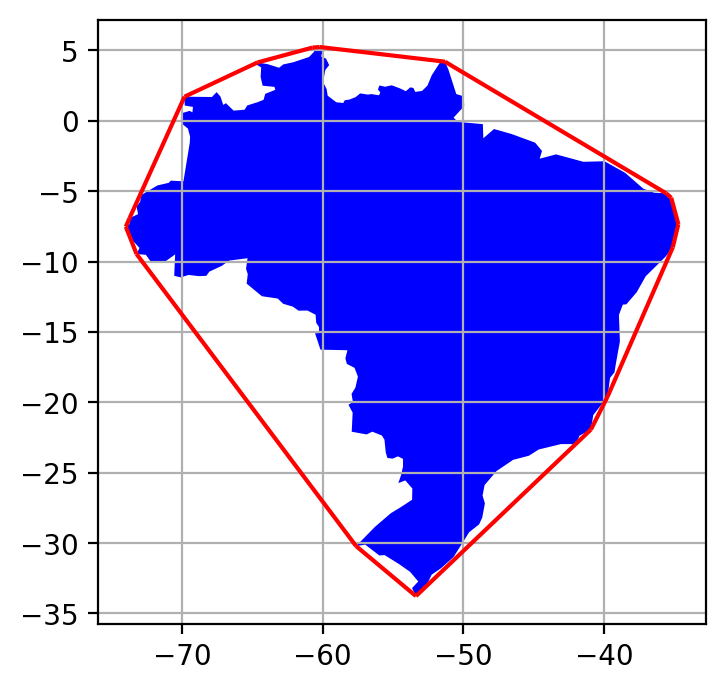

In [9]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

edges = geopandas.GeoDataFrame({'edges': lines}).set_geometry('edges')
edges.plot(ax=ax, color='r')

polygons.plot(ax=ax, color='b')